In [1]:
import sys, os, glob, scipy, sqlite3, json, matplotlib, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def ttest_1samp(dat, popmean = .5, verbose = True):
    if verbose:
        print('SD: ',np.std(dat))
        print('Stats:')
    stats = scipy.stats.ttest_1samp(dat, popmean = popmean)
    if verbose:
        print(stats)
        print('Cohen d:')
    coh_d = (np.mean(dat) - popmean)/np.std(dat)
    if verbose:
        print(coh_d)
    return(stats, coh_d)

def ttest_2samp(dat1, dat2):
    print('SD dat 1: ',np.std(dat1))
    print('SD dat 2: ',np.std(dat2))
    print('Stats:')
    stats = scipy.stats.ttest_ind(dat1, dat2)
    print(stats)
    print('Cohen d:')
    nx = len(dat1)
    ny = len(dat2)
    dof = nx + ny - 2
    coh_d = ((np.mean(dat1) - np.mean(dat2)) /
             np.sqrt(((nx-1)*np.std(dat1, ddof=1) ** 2 + (ny-1)*np.std(dat2, ddof=1) ** 2) / dof))
    print(coh_d)
    return(stats, coh_d)

### Load data

In [3]:
a = !pwd
baseDir = '/'.join(a[0].split('/')[0:-2])
print(baseDir)

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study4_InspectionGame


In [4]:
groups = ['batch1','batch2','batch3','batch4','batch5','batch6','batch7','batch8']

In [5]:
WS_dat = pd.read_csv(baseDir + '/Data/Cleaned/WS_dat.csv',index_col = 0)
quiz_dat = pd.read_csv(baseDir + '/Data/Cleaned/quiz_dat.csv',index_col = 0)
SPG_dat = pd.read_csv(baseDir + '/Data/Cleaned/SPG_dat.csv',index_col = 0)

## Plot some results work/shirk

In [6]:
WS_cond_dat = WS_dat.groupby(['subID','player_type'],as_index=False).mean()

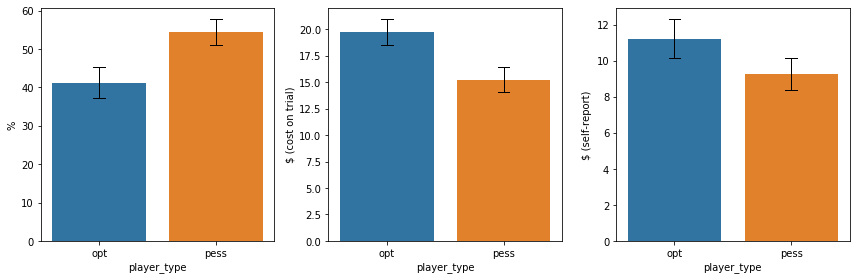

In [7]:
sns.set_palette('tab10')
fig,ax = plt.subplots(nrows=1,ncols=3, figsize=[12,4])
sns.barplot(data = WS_cond_dat, x = 'player_type', y = 'work_confidence',
           errwidth = 1, errcolor = 'k', capsize=.1, ax = ax[0])
sns.barplot(data = WS_cond_dat, x = 'player_type', y = 'cost',
           errwidth = 1, errcolor = 'k', capsize=.1, ax = ax[1])
sns.barplot(data = WS_cond_dat, x = 'player_type', y = 'pay_inspect',
           errwidth = 1, errcolor = 'k', capsize=.1, ax = ax[2])
ax[0].set(ylabel = '%')
ax[1].set(ylabel = '$ (cost on trial)')
ax[2].set(ylabel = '$ (self-report)')
# plt.ylabel('Willingness to pay for Inspection ($)')
# plt.xlabel('Player type')
# plt.title('Pilot data Work/Shirk task (n = %i)'%len(WS_dat['subID'].unique()))
plt.tight_layout()

In [8]:
WS_cond_dat.groupby('player_type').mean()

,subID,cost,score,trial,work_confidence,block,pay_inspect,psiturk_status,bonus,choice_num
player_type,,,,,,,,,,
opt,6748.51634,19.782135,5.667538,7.0,41.169935,0.490196,11.215686,4.0,0.420458,0.592593
pess,6748.51634,15.215686,32.278431,7.0,54.529412,0.509804,9.248366,4.0,0.420458,0.491939


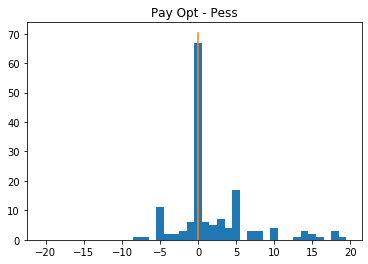

In [9]:
pay_by_cond = WS_cond_dat.pivot(index='subID', columns = 'player_type',
                                values = 'pay_inspect').reset_index()
pay_by_cond['diff'] = pay_by_cond['opt'] - pay_by_cond['pess']
plt.hist(pay_by_cond['diff'],bins=np.arange(-20.5,20.5));
plt.plot([0,0],plt.ylim());
plt.title('Pay Opt - Pess');

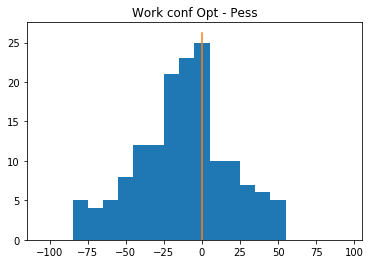

In [10]:
conf_by_cond = WS_cond_dat.pivot(index='subID', columns = 'player_type',
                                values = 'work_confidence').reset_index()
conf_by_cond['diff'] = conf_by_cond['opt'] - conf_by_cond['pess']
plt.hist(conf_by_cond['diff'],bins=np.arange(-105,105,10));
plt.plot([0,0],plt.ylim());
plt.title('Work conf Opt - Pess');

##### Plot decision curves

In [11]:
subIDs = WS_dat['subID'].unique()

In [12]:
def plot_dec_curve(subdat, fit_reg = False, axes = None):
    
    colors = sns.color_palette('tab10')[:2]
    subID = subdat['subID'].unique()[0]
    if axes is None:
        fig,axes=plt.subplots(nrows=1,ncols=2, figsize = [8,3],
                    sharex=False, sharey=True)
    for pti, pt in enumerate(['opt','pess']):
        sns.regplot(data = subdat.query('player_type == @pt'),
                        x = 'cost', y = 'choice_num', fit_reg = fit_reg, logistic=True,
                        n_boot=500, y_jitter=.01, scatter_kws={"s": 60}, ax=axes[pti],
                       color = colors[pti])
        axes[pti].set(title = 'Sub %s, %s'%(subID, pt), xlim = [0,30], ylim = [0,1],
                        ylabel = 'Choice', xlabel = 'Cost of inspecting ($)')

## Compute mean of final 5 choices as indifference point

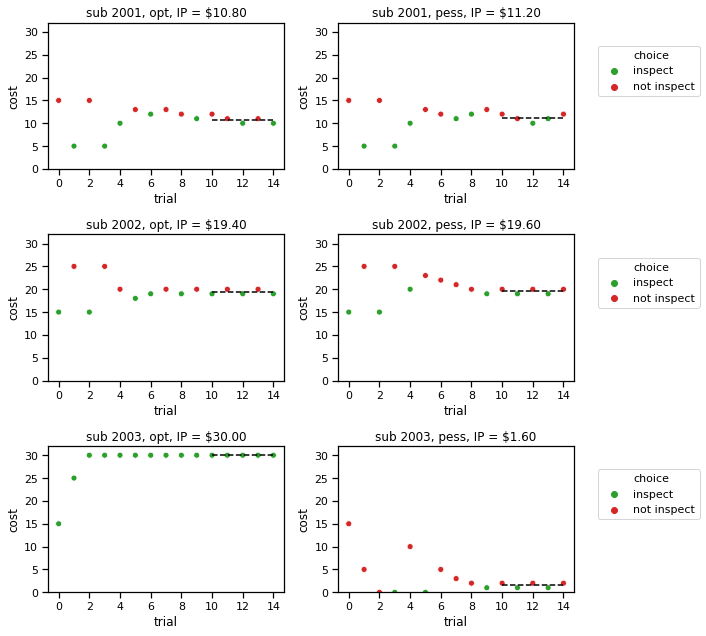

In [13]:
sns.set_context('notebook')
n_subs = 3
fig,axes = plt.subplots(n_subs,2, figsize = [10,3*n_subs])
sns.set_palette([sns.color_palette('tab10')[i] for i in [2,3]])
for sub in range(n_subs):
    subID = subIDs[sub]
    subdat = WS_dat.query('subID == @subID')
    for pti,pt in enumerate(['opt','pess']):
        ax = axes[sub,pti]
        dat = subdat.query('player_type == @pt')
        sns.scatterplot(data = dat, x = 'trial', y = 'cost', hue = 'choice', ax=ax,
                       hue_order = ['inspect', 'not inspect'])
        [hand,lab] = ax.get_legend_handles_labels()
        IP = dat.query('trial > 9')['cost'].mean()
        ax.plot(np.arange(10,15),np.repeat(IP,5),'k--')
        ax.set(title = 'sub %s, %s, IP = $%.2f'%(subID,pt, IP),
                    xticks = np.arange(0,15,2), yticks = np.arange(0,31,5), ylim = [0,32])
        if pti == 0:
            ax.legend().remove()
        elif pti == 1:
            ax.legend(loc = [1.1,.5])
plt.tight_layout()
# plt.savefig(baseDir + '/Results/Behavior.pdf',transparent = True,
#            bbox_inches = 'tight')

## Plot sigmoids

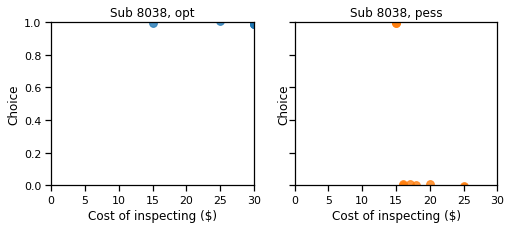

In [14]:
subID = "8038"
subdat = WS_dat.query('subID == @subID')
plot_dec_curve(subdat, fit_reg=True)

## Compare SPG score to WS behavior

In [15]:
SPG_scores = SPG_dat.groupby(['subID','player_type'],as_index=False
                            ).mean()[['subID','player_type','score']]
SPG_scores_wide = SPG_scores.pivot(index = 'subID', columns = 'player_type', values = 'score').reset_index()
SPG_scores_wide['diff'] = SPG_scores_wide['opt'] - SPG_scores_wide['pess']
SPG_scores_wide['mean'] = (SPG_scores_wide['opt'] + SPG_scores_wide['pess'])/2
SPG_scores_wide.head()

player_type,subID,opt,pess,diff,mean
0,2001,0.9375,0.5000,0.4375,0.71875
1,2002,0.7500,0.4375,0.3125,0.59375
2,2003,0.9375,0.9375,0.0000,0.93750
3,2004,0.8750,0.6250,0.2500,0.75000
4,2005,0.6250,0.8125,-0.1875,0.71875


(0, 1)

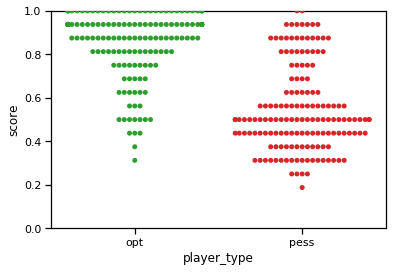

In [16]:
sns.swarmplot(data = SPG_scores, x = 'player_type', y = 'score')
plt.ylim([0,1])

##### Quantify work/shirk effect

In [17]:
IPs = WS_dat.query('trial >9').groupby(['subID','player_type'],as_index=False).mean()[['subID','player_type','cost']]
IPs_wide = IPs.pivot(index = 'subID', columns = 'player_type', values = 'cost').reset_index()
IPs_wide['diff'] = IPs_wide['opt'] - IPs_wide['pess']
IPs_wide.head()

player_type,subID,opt,pess,diff
0,2001,10.8,11.2,-0.4
1,2002,19.4,19.6,-0.2
2,2003,30.0,1.6,28.4
3,2004,6.2,6.2,0.0
4,2005,11.6,10.8,0.8


In [18]:
scipy.stats.ttest_1samp(IPs_wide['diff'],0)

Ttest_1sampResult(statistic=6.573709530486436, pvalue=7.407496779583807e-10)

In [19]:
scipy.stats.wilcoxon(IPs_wide['diff'])

WilcoxonResult(statistic=2031.5, pvalue=7.02389699502781e-09)

In [20]:
ttest_1samp(IPs_wide['diff'], 0)

SD:  9.350407479853546
Stats:
Ttest_1sampResult(statistic=6.573709530486436, pvalue=7.407496779583807e-10)
Cohen d:
0.5331982510681736


(Ttest_1sampResult(statistic=6.573709530486436, pvalue=7.407496779583807e-10),
 0.5331982510681736)

In [21]:
IPs_wide.describe()

player_type,subID,opt,pess,diff
count,153.000000,153.000000,153.000000,153.000000
mean,6748.516340,20.096732,15.111111,4.985621
std,2442.573783,8.830244,8.745131,9.381115
min,2001.000000,0.000000,0.000000,-16.800000
25%,4015.000000,13.400000,8.000000,-0.200000
50%,8028.000000,21.600000,15.400000,2.000000
75%,9021.000000,28.400000,21.000000,10.000000
max,9080.000000,30.000000,30.000000,30.000000


##### Merge across tasks

In [22]:
SPG_pess_order = SPG_dat[['subID','block','player_type']].drop_duplicates().pivot(index='subID',columns = 'player_type', values='block').reset_index()[['subID','pess']]
SPG_pess_order.columns = ['subID','pess_order']

In [23]:
task_dat = SPG_scores_wide.merge(IPs_wide, on = 'subID', suffixes = ['_SPG','_WS']).merge(SPG_pess_order, on='subID')
conf_by_cond = conf_by_cond.rename(columns = {'diff':'conf_diff'})
pay_by_cond = pay_by_cond.rename(columns = {'diff':'pay_diff'})
task_dat = task_dat.merge(conf_by_cond[['subID','conf_diff']], on = 'subID')
task_dat = task_dat.merge(pay_by_cond[['subID','pay_diff']], on = 'subID')
task_dat.head()

,subID,opt_SPG,pess_SPG,diff_SPG,mean,opt_WS,pess_WS,diff_WS,pess_order,conf_diff,pay_diff
0,2001,0.9375,0.5000,0.4375,0.71875,10.8,11.2,-0.4,0,0.0,0.0
1,2002,0.7500,0.4375,0.3125,0.59375,19.4,19.6,-0.2,1,0.0,0.0
2,2003,0.9375,0.9375,0.0000,0.93750,30.0,1.6,28.4,1,-85.0,4.0
3,2004,0.8750,0.6250,0.2500,0.75000,6.2,6.2,0.0,0,-1.0,0.0
4,2005,0.6250,0.8125,-0.1875,0.71875,11.6,10.8,0.8,1,-20.0,1.0


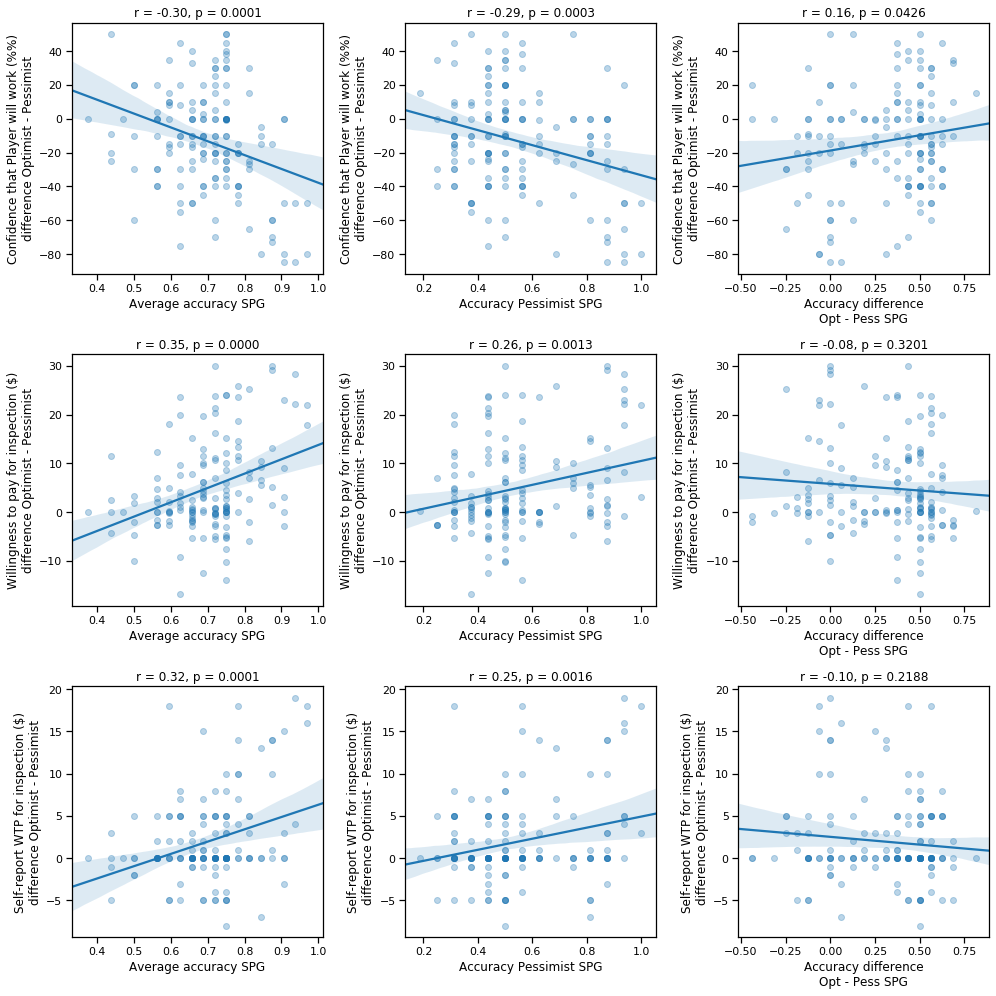

In [24]:
fix,axes = plt.subplots(ncols=3,nrows=3,figsize=[14,14])
x_cols = ['mean','pess_SPG','diff_SPG']
x_cols_long = ['Average accuracy SPG', 'Accuracy Pessimist SPG', 'Accuracy difference\nOpt - Pess SPG']
y_cols = ['conf_diff','diff_WS','pay_diff']
y_cols_long = ['Confidence that Player will work (%%)\ndifference Optimist - Pessimist',
              'Willingness to pay for inspection ($)\ndifference Optimist - Pessimist',
              'Self-report WTP for inspection ($)\ndifference Optimist - Pessimist']
for xi,x_col in enumerate(x_cols):
    for yi,y_col in enumerate(y_cols):
        ax = axes[yi,xi]
        stats = scipy.stats.pearsonr(task_dat[x_col],task_dat[y_col])
        sns.regplot(data = task_dat, x = x_col, y = y_col, ax = ax, scatter_kws = {'alpha':.3},
                    color = sns.color_palette('tab10')[0])
        ax.set(xlabel = x_cols_long[xi],
               ylabel = y_cols_long[yi], title = 'r = %.2f, p = %.4f'%(stats[0],stats[1]))
plt.tight_layout()

##### Plot altogether

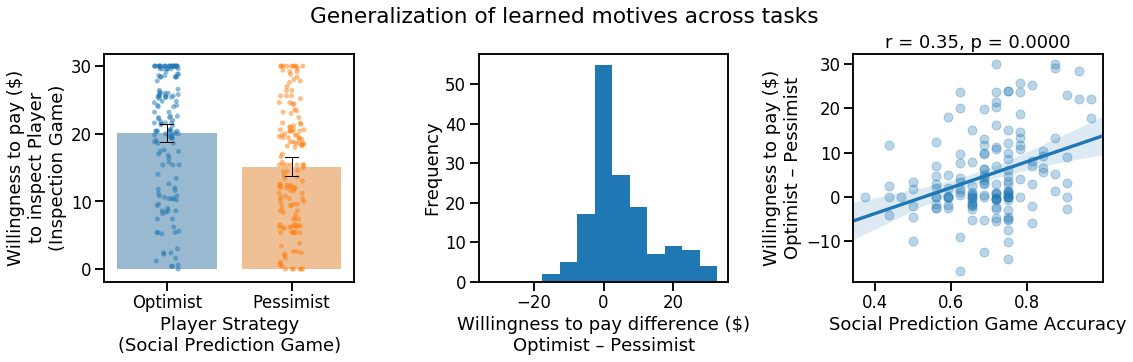

In [25]:
sns.set_context('talk')
sns.set_palette('tab10')
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=[16,5])
sns.barplot(data = IPs, x = 'player_type', y = 'cost', ax = ax[0],
            alpha = .5, errwidth = 0, zorder = 0)
sns.stripplot(data = IPs, x = 'player_type', y = 'cost', ax = ax[0],
              alpha = .5, zorder = 1)
sns.barplot(data = IPs, x = 'player_type', y = 'cost', ax = ax[0],
            alpha = 0, errwidth = 1, errcolor = 'k', capsize=.1, zorder = 2)
ax[1].hist(IPs_wide['diff'], bins = np.arange(-32.5,32.6,5))
sns.regplot(data = task_dat, x = 'mean', y = 'diff_WS', ax = ax[2], scatter_kws = {'alpha':.3})
stats = scipy.stats.pearsonr(task_dat['mean'],task_dat['diff_WS'])

ax[0].set(xlabel = 'Player Strategy\n(Social Prediction Game)', xticklabels = ['Optimist','Pessimist'],
         ylabel = 'Willingness to pay ($)\nto inspect Player\n(Inspection Game)')
ax[1].set(xlabel = 'Willingness to pay difference ($)\nOptimist – Pessimist',
          ylabel = 'Frequency')
ax[2].set(xlabel = 'Social Prediction Game Accuracy',
          ylabel = 'Willingness to pay ($)\nOptimist – Pessimist',
          title = 'r = %.2f, p = %.4f'%(stats[0],stats[1]))
plt.suptitle('Generalization of learned motives across tasks',y=1.02)
plt.tight_layout()
# plt.savefig(baseDir + '/Figures/plot1.pdf',bbox_inches='tight', transparent=True)

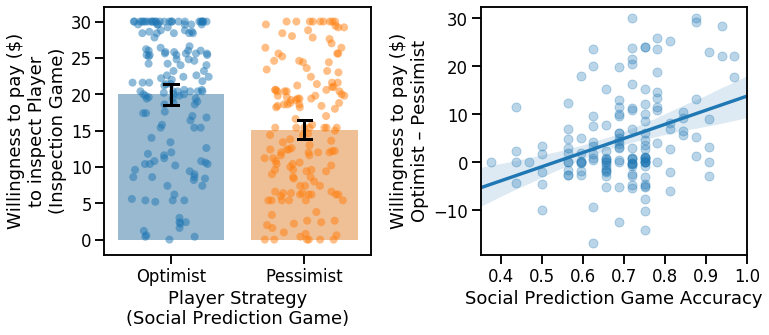

In [26]:
sns.set_context('talk')
sns.set_palette('tab10')
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[11,5])
sns.barplot(data = IPs, x = 'player_type', y = 'cost', ax = ax[0],
            alpha = .5, errwidth = 0, zorder = 0)
sns.stripplot(data = IPs, x = 'player_type', y = 'cost', ax = ax[0],
              alpha = .5, zorder = 1, jitter=.3, size=8)
sns.barplot(data = IPs, x = 'player_type', y = 'cost', ax = ax[0],
            alpha = 0, errwidth = 3, errcolor = 'k', capsize=.1, zorder = 2)
sns.regplot(data = task_dat, x = 'mean', y = 'diff_WS', ax = ax[1], scatter_kws = {'alpha':.3})

ax[0].set(xlabel = 'Player Strategy\n(Social Prediction Game)', xticklabels = ['Optimist','Pessimist'],
         ylabel = 'Willingness to pay ($)\nto inspect Player\n(Inspection Game)')
ax[1].set(xlabel = 'Social Prediction Game Accuracy',
          ylabel = 'Willingness to pay ($)\nOptimist – Pessimist',
         xticks = np.arange(0.4,1.01,.1), xlim = [0.35,1])
plt.tight_layout()
# plt.savefig(baseDir + '/Figures/plot1b.pdf',bbox_inches='tight', transparent=True)

## Relationship between Opt-Pess distinguishing and IG bonus

##### Compute earnings in last 5 trials and use that as 'earnings'.

In [27]:
WS_dat['earnings'] = np.nan

In [28]:
for ri,row in WS_dat.iterrows():
    cost = row['cost']
    if row['player_type'] == 'pess':
        if row['choice'] == 'not inspect':
            WS_dat.at[ri,'earnings'] = 40
        elif row['choice'] == 'inspect':
            WS_dat.at[ri,'earnings'] = 40 - cost
    elif row['player_type'] == 'opt':
        if row['choice'] == 'not inspect':
            WS_dat.at[ri,'earnings'] = 0
        elif row['choice'] == 'inspect':
            WS_dat.at[ri,'earnings'] = 30 - cost

In [29]:
IG_earnings = WS_dat.query('cost == 15').groupby('subID',as_index=False).mean()[['subID','score']]
IG_earnings.head()

,subID,score
0,2001,20.0
1,2002,20.0
2,2003,27.5
3,2004,20.0
4,2005,20.0


##### Merge with task data

In [30]:
task_earn_dat = task_dat.merge(IG_earnings[['subID','score']].drop_duplicates(), on = 'subID')

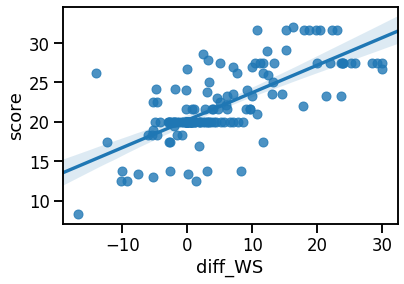

In [31]:
sns.regplot(data = task_earn_dat, x = 'diff_WS', y = 'score')

In [32]:
scipy.stats.pearsonr(task_earn_dat['diff_WS'], task_earn_dat['score'])

(0.7219383657727374, 6.348075557118766e-26)